# Question Type and Complexity Dummy Baseline Experiments
#### Multilingual Question Type Classification and Complexity Prediction

This notebook implements simple baselines for both question type classification (polar vs. content) and complexity regression.

We'll use simple dummy models from scikit-learn as baselines and use these results for comparison with ML models.

##### Author: Robin Kokot
##### Date: March 2025


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report,mean_squared_error, mean_absolute_error, r2_score)
from datasets import load_dataset
from scipy.sparse import vstack
import wandb
import logging

# ==================== Set up displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# ==================== Set up seed constant
SEED = 69
np.random.seed(SEED)


In [3]:
# ==================== Wandb config
run = wandb.init(project="MAIthesis", name="dummy-baselines", tags=["baseline", "dummy-models", "question-classification", "complexity-regression", "tfidf"], job_type="model-training", dir="/home/robin/Research/qtype-eval/scripts/experiments/baselines")

config = wandb.config
config.logreg_max_iter = 1000
config.logreg_C = 1.0
config.linear_fit_intercept = True
config.random_state = SEED

wandb.run.notes = "Combined control experiments with dummy models for both question type classification and complexity regression using TF-IDF vectors"


In [ ]:
# ==================== Dataset loading and label config
dataset = load_dataset("rokokot/question-type-and-complexity-v2")

train_df = pd.DataFrame(dataset['train'])
dev_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

y_class_train = np.array(dataset['train']['question_type'])  
y_class_dev = np.array(dataset['validation']['question_type'])
y_class_test = np.array(dataset['test']['question_type'])

def normalize_complexity_scores(df):
    df['lang_norm_complexity_score'] = 0.0
    for language, group in df.groupby('language'):
        min_score = group['complexity_score'].min()
        max_score = group['complexity_score'].max()
        if min_score == max_score:
            df.loc[df['language'] == language, 'lang_norm_complexity_score'] = 0.5
        else:
            normalized_scores = (group['complexity_score'] - min_score) / (max_score - min_score)
            df.loc[df['language'] == language, 'lang_norm_complexity_score'] = normalized_scores.values

    return df

train_df = normalize_complexity_scores(train_df)
dev_df = normalize_complexity_scores(dev_df)
test_df = normalize_complexity_scores(test_df)

y_reg_train = np.array(train_df['lang_norm_complexity_score']) 
y_reg_dev = np.array(dev_df['lang_norm_complexity_score'])
y_reg_test = np.array(test_df['lang_norm_complexity_score'])

langs_train = np.array(train_df['language'])
langs_dev = np.array(dev_df['language'])
langs_test = np.array(test_df['language'])

print(f"Classification label distribution (train): {np.bincount(y_class_train)}")
print(f"Classification label distribution (test): {np.bincount(y_class_test)}")
print(f"Classification label distribution (dev): {np.bincount(y_class_dev)}")

print(f"\nRegression target stats (train): mean={y_reg_train.mean():.4f}, std={y_reg_train.std():.4f}, min={y_reg_train.min():.4f}, max={y_reg_train.max():.4f}")
print(f"Regression target stats (test): mean={y_reg_test.mean():.4f}, std={y_reg_test.std():.4f}, min={y_reg_test.min():.4f}, max={y_reg_test.max():.4f}")
print(f"Regression target stats (dev): mean={y_reg_dev.mean():.4f}, std={y_reg_dev.std():.4f}, min={y_reg_dev.min():.4f}, max={y_reg_dev.max():.4f}")

num_examples = 5
for i in range(num_examples):
    print(f"\nExample {i+1}:")
    print(f"Text: {train_df['text'].iloc[i]}")
    print(f"Language: {train_df['language'].iloc[i]}")
    print(f"Question Type: {train_df['question_type'].iloc[i]}")
    print(f"Original Complexity Score: {train_df['complexity_score'].iloc[i]:.4f}")
    print(f"Language-Normalized Complexity Score: {train_df['lang_norm_complexity_score'].iloc[i]:.4f}")


Loading dataset...
Classification label distribution (train): [3778 3682]
Classification label distribution (test): [367 352]
Classification label distribution (dev): [223 218]

Regression target stats (train): mean=0.3855, std=0.1693, min=0.0000, max=1.0000
Regression target stats (test): mean=0.4294, std=0.2127, min=0.0000, max=1.0000
Regression target stats (dev): mean=0.4466, std=0.2359, min=0.0000, max=1.0000

===== Example Questions with Labels and Complexity Scores =====

Example 1:
Text: Onko Tampereen rantatunneli Suomen pisin maantietunneli?
Language: fi
Question Type: 1
Original Complexity Score: 1.4590
Language-Normalized Complexity Score: 0.3608

Example 2:
Text: В каком фильме снимался Дзюн Фукуяма?
Language: ru
Question Type: 0
Original Complexity Score: 1.2430
Language-Normalized Complexity Score: 0.2536

Example 3:
Text: Kuka oli Mary Jane Watsonin lempisukulainen perheen ulkopuolelta?
Language: fi
Question Type: 0
Original Complexity Score: 1.4550
Language-Normalized 

In [7]:
# ==================== TFIDF vectors loading
tfidf_dir = "/home/robin/Research/qtype-eval/scripts/data/vectors"
train_vectors = f"{tfidf_dir}/tfidf_vectors_train.pkl"
dev_vectors = f"{tfidf_dir}/tfidf_vectors_dev.pkl"
test_vectors = f"{tfidf_dir}/tfidf_vectors_test.pkl"


print("Loading TF-IDF vectors...")
with open(train_vectors, 'rb') as v:    
    X_train = pickle.load(v)
with open(dev_vectors, 'rb') as v:
    X_dev = pickle.load(v)
with open(test_vectors, 'rb') as v:
    X_test = pickle.load(v)
print("TF-IDF vectors loaded successfully.")

print(f"Train - Features: {X_train.shape[0]}, Classification Labels: {y_class_train.shape[0]}, Regression Targets: {y_reg_train.shape[0]}")
print(f"Test - Features: {X_test.shape[0]}, Classification Labels: {y_class_test.shape[0]}, Regression Targets: {y_reg_test.shape[0]}")
print(f"Validation - Features: {X_dev.shape[0]}, Classification Labels: {y_class_dev.shape[0]}, Regression Targets: {y_reg_dev.shape[0]}")


Loading TF-IDF vectors...
TF-IDF vectors loaded successfully.
Train - Features: 7460, Classification Labels: 7460, Regression Targets: 7460
Test - Features: 719, Classification Labels: 719, Regression Targets: 719
Validation - Features: 441, Classification Labels: 441, Regression Targets: 441


In [8]:
wandb.config.update({"feature_type": "TF-IDF","train_samples": X_train.shape[0],"test_samples": X_test.shape[0],"dev_samples": X_dev.shape[0],"feature_dim": X_train.shape[1]})

In [9]:
# ==================== Helper functions for models
sparse_matrices = [matrix[0] for matrix in X_train] 
X_train_stacked = vstack(sparse_matrices)

sparse_matrices_test = [matrix[0] for matrix in X_test]
X_test_stacked = vstack(sparse_matrices_test)

# clf implementation

In [ ]:
# ==================== Helper functions for classification
def evaluate_classifier(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.tight_layout()
    
    clean_name = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    wandb.log({f"classification_{clean_name}_accuracy": accuracy,f"classification_{clean_name}_precision": precision,f"classification_{clean_name}_recall": recall,f"classification_{clean_name}_f1": f1,f"classification_{clean_name}_cm": wandb.Image(plt)})      #tracking

    plt.close()
    
    return {'accuracy': accuracy,'precision': precision,'recall': recall,'f1': f1,'confusion_matrix': cm}

In [12]:
# ==================== Dummy classification models
dummy_strategies = ['stratified', 'most_frequent', 'uniform']
dummy_clf_results = {}

for strategy in dummy_strategies:
    print(f"\nTraining DummyClassifier with strategy: {strategy}")
    dummy_clf = DummyClassifier(strategy=strategy, random_state=SEED)
    
    start_time = time.time()
    dummy_clf.fit(X_train_stacked, y_class_train)
    train_time = time.time() - start_time
    print(f"Training time: {train_time:.4f} seconds")
    
    start_time = time.time()
    y_pred = dummy_clf.predict(X_test_stacked)
    predict_time = time.time() - start_time
    
    results = evaluate_classifier(y_class_test, y_pred, f"Dummy Classifier ({strategy})")
    results['train_time'] = train_time
    results['predict_time'] = predict_time
    dummy_clf_results[strategy] = results
    
    wandb.log({f"classification_dummy_{strategy}_train_time": train_time, f"classification_dummy_{strategy}_predict_time": predict_time})           #tracking



Training DummyClassifier with strategy: stratified
Training time: 0.0040 seconds
Dummy Classifier (stratified) - Accuracy: 0.4645, F1 Score: 0.4444
Confusion Matrix:
[[180 187]
 [198 154]]

Training DummyClassifier with strategy: most_frequent
Training time: 0.0030 seconds
Dummy Classifier (most_frequent) - Accuracy: 0.5104, F1 Score: 0.0000
Confusion Matrix:
[[367   0]
 [352   0]]


/home/robin/.cache/pypoetry/virtualenvs/qtype-eval-pAepV5Z2-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DummyClassifier with strategy: uniform
Training time: 0.0031 seconds
Dummy Classifier (uniform) - Accuracy: 0.5160, F1 Score: 0.5233
Confusion Matrix:
[[180 187]
 [161 191]]


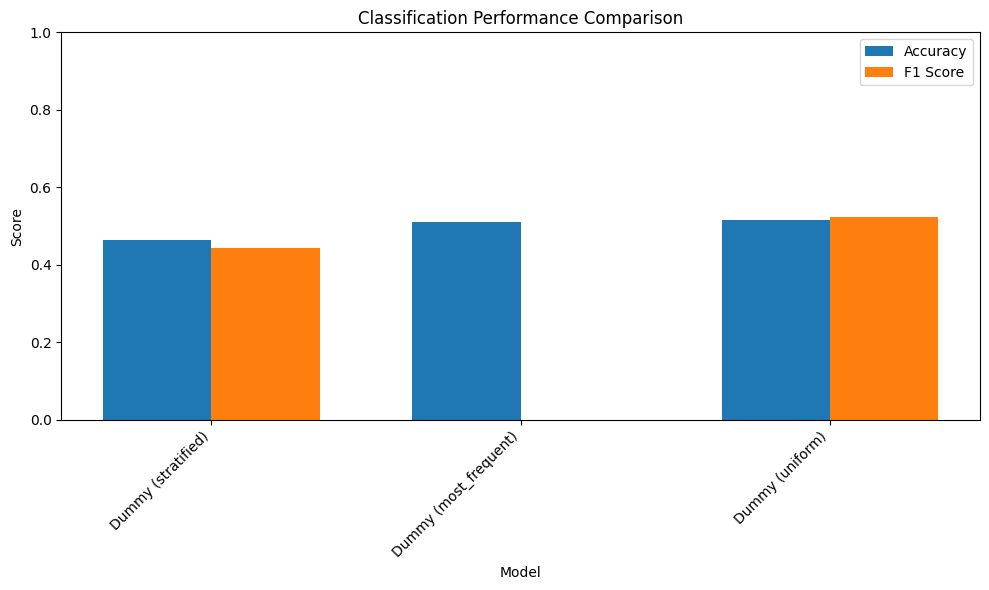

In [16]:
# ==================== Classification performance visualization
plt.figure(figsize=(10, 6))
model_names = [f"Dummy ({s})" for s in dummy_strategies]
accuracies = [dummy_clf_results[s]['accuracy'] for s in dummy_strategies]
f1_scores = [dummy_clf_results[s]['f1'] for s in dummy_strategies]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Classification Performance Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
wandb.log({"classification_performance_comparison": wandb.Image(plt)})              #tracking
plt.show()

# reg implementaton

In [17]:
# ==================== Helper functions for regression
def evaluate_regressor(y_true, y_pred, model_name):
    """Evaluate regressor performance and print results"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual Complexity')
    plt.ylabel('Predicted Complexity')
    plt.title(f'Predicted vs. Actual Complexity ({model_name})')
    plt.tight_layout()
    
    clean_name = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    wandb.log({f"regression_{clean_name}_rmse": rmse,f"regression_{clean_name}_mae": mae,f"regression_{clean_name}_r2": r2,f"regression_{clean_name}_scatter": wandb.Image(plt)})           #tracking
    plt.close()
    
    return {'rmse': rmse,'mae': mae,'r2': r2}

In [18]:
# ==================== Dummy regression models
dummy_strategies = ['mean', 'median']
dummy_reg_results = {}

for strategy in dummy_strategies:
    print(f"\nTraining DummyRegressor with strategy: {strategy}")
    dummy_reg = DummyRegressor(strategy=strategy)
    
    start_time = time.time()
    dummy_reg.fit(X_train, y_reg_train)
    train_time = time.time() - start_time
    print(f"Training time: {train_time:.4f} seconds")
    
    start_time = time.time()
    y_pred = dummy_reg.predict(X_test)
    predict_time = time.time() - start_time
    
    results = evaluate_regressor(y_reg_test, y_pred, f"Dummy Regressor ({strategy})")
    results['train_time'] = train_time
    results['predict_time'] = predict_time
    dummy_reg_results[strategy] = results
    
    wandb.log({f"regression_dummy_{strategy}_train_time": train_time,f"regression_dummy_{strategy}_predict_time": predict_time})


Training DummyRegressor with strategy: mean
Training time: 0.0017 seconds
Dummy Regressor (mean) - RMSE: 0.2172, MAE: 0.1716, R²: -0.0426

Training DummyRegressor with strategy: median
Training time: 0.0028 seconds
Dummy Regressor (median) - RMSE: 0.2203, MAE: 0.1731, R²: -0.0724


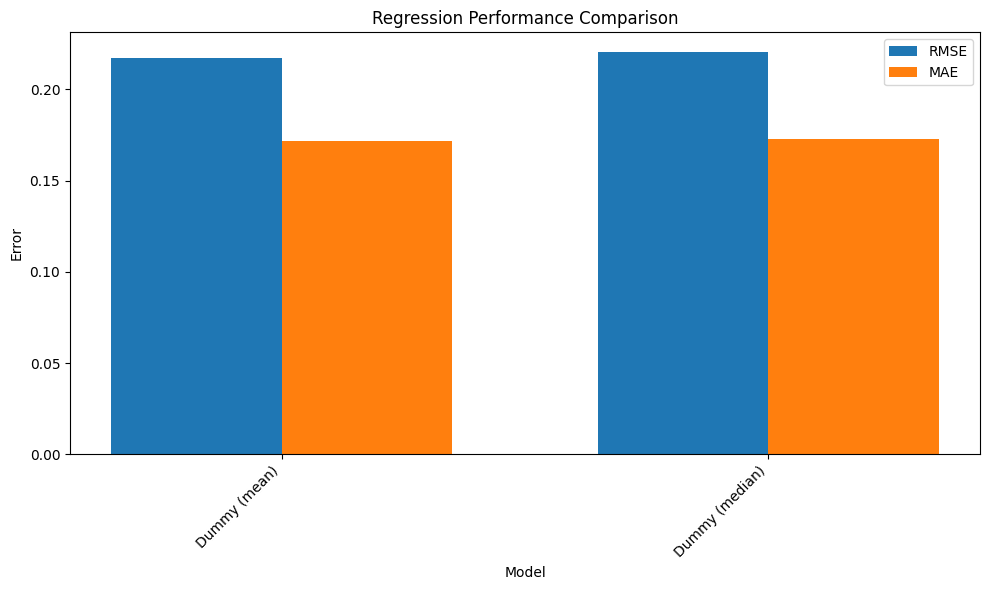

In [19]:
# ==================== Regression performance visualization
plt.figure(figsize=(10, 6))
model_names = [f"Dummy ({s})" for s in dummy_strategies] 
rmse_values = [dummy_reg_results[s]['rmse'] for s in dummy_strategies] 
mae_values = [dummy_reg_results[s]['mae'] for s in dummy_strategies]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, rmse_values, width, label='RMSE')
plt.bar(x + width/2, mae_values, width, label='MAE')
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Regression Performance Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
wandb.log({"regression_performance_comparison": wandb.Image(plt)})              #tracking
plt.show()

## Control labels 

## Individual signals regression


In [20]:
wandb.finish()


classification_dummy_classifier_most_frequent_accuracy,▁▁
classification_dummy_classifier_most_frequent_f1,▁▁
classification_dummy_classifier_most_frequent_precision,▁▁
classification_dummy_classifier_most_frequent_recall,▁▁
classification_dummy_classifier_stratified_accuracy,▁▁
classification_dummy_classifier_stratified_f1,▁▁
classification_dummy_classifier_stratified_precision,▁▁
classification_dummy_classifier_stratified_recall,▁▁
classification_dummy_classifier_uniform_accuracy,▁▁
classification_dummy_classifier_uniform_f1,▁▁
classification_dummy_classifier_uniform_precision,▁▁
